We played around with the London transit data, exploring what it tells us about where people live and comparing it to the census estimation. We have the aim down to two components, or key questions:

1. Can we use transit network ridership data in order to estimate population distribution?
1. Can we use transit network ridership data in order to describe the home-work dynamics of a city?

In this section we will delve deeper into the first question, and we address the second in another section. But the two problems are very related: if we can reliably extract population from network transit data, we can use this to classify areas into residential and business districts, and vice versa.

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, spatial
from sklearn import preprocessing
import shapely

## Data

Once again we start by getting the necessary data:
* London station names and locations
* London ward shapes
* London ward/borough census

#### Entrance/Exit Counts

In [2]:
PROJECTION=32630

In [3]:
counts_en = pd.read_csv('/Users/itto/Documents/cities/data/london/counts/En17week_mod.csv', skiprows=6).set_index(' Station')
counts_ex = pd.read_csv('/Users/itto/Documents/cities/data/london/counts/Ex17week.csv', skiprows=6).set_index(' Station')

# We only care about the time columns
time_columns = counts_en.columns[4:-8]

# Easier to work with stations as columns, so transpose
data_en = counts_en.loc[:, time_columns].T
data_ex = counts_ex.loc[:, time_columns].T

# Remove "Total" column
data_en.drop('Total',axis=1,inplace=True)
data_ex.drop('Total',axis=1,inplace=True)

# Extract the first time
data_en.index = data_en.index.str[:4]
data_ex.index = data_en.index.str[:4]

# Convert to datetime format
data_en.index = pd.to_datetime(data_en.index, format='%H%M')
data_ex.index = pd.to_datetime(data_en.index, format='%H%M')

# Create a time of day index that we can use from now on
time_of_day = {
    6: 'morning',
    7: 'morning',
    8: 'morning',
    9: 'morning',
    11: 'off',
    12: 'off',
    13: 'off',
    14: 'off',
    16: 'afternoon',
    17: 'afternoon',
    18: 'afternoon',
    19: 'afternoon'
}
time_of_day = data_en.index.hour.map(time_of_day).to_series()
time_of_day[time_of_day.isnull()] = 'night'
time_of_day = time_of_day.values

In [4]:
# Get the entrances and exists for each time interval
entrances = data_en.groupby(time_of_day).sum().T
exits = data_ex.groupby(time_of_day).sum().T

#### Station location

In [728]:
station_geom = gpd.read_file('../data/london/shapes/stations/stations_mod.shp')
# Change to UTM
station_geom.to_crs(epsg=PROJECTION, inplace=True)
# Remove the word "Station"
station_geom.columns = station_geom.columns.str.lower()
station_geom.rename(columns={'geometry':'location'}, inplace=True)
station_geom.name = station_geom.name.str.replace('\t','').str.replace('\n','').str.replace(' Station','')
station_geom.set_index('name', drop=True, inplace=True)

# Read Voronoi cells
station_voronoi = gpd.read_file('../data/london/shapes/stations/voronoi.shp')
station_voronoi.to_crs(epsg=PROJECTION, inplace=True)
station_voronoi.columns = station_voronoi.columns.str.lower()
station_voronoi.rename(columns={'geometry':'cell'}, inplace=True)
station_voronoi.name = station_voronoi.name.str.replace('\t','').str.replace('\n','').str.replace(' Station','')
station_voronoi.set_index('name', drop=True, inplace=True)

# Combine Voronoi with location
station_geom['cell'] = station_voronoi.reindex(station_geom.index).cell


#### Wards/borough geometry

In [656]:
oa_geom = gpd.read_file('../data/london/shapes/oa/OA_2011_London_gen_MHW.shp')
oa_geom.to_crs(epsg=PROJECTION, inplace=True)
oa_geom.columns = oa_geom.columns.str.lower()
# Some invalid geoms. Fix them.
oa_geom.geometry = oa_geom.buffer(0)

In [7]:
ward_geom = gpd.read_file('/Users/itto/Documents/cities/data/london/shapes/wards/London_Ward.shp')
ward_geom.to_crs(epsg=PROJECTION, inplace=True)
ward_geom.columns = ward_geom.columns.str.lower()

#### Census data

In [1018]:
ages = [str(age) for age in range(18,65)]
oa_pop = pd.read_csv('../data/london/census/output_area_mid-2017-estimates-london.csv', skiprows=4, usecols=['OA11CD', 'LSOA11CD', 'All Ages']+ages)
oa_pop.rename(columns={'All Ages':'population'}, inplace=True)
oa_pop.columns = oa_pop.columns.str.lower()

# Remove apostrophes for thousand separators
oa_pop.population = oa_pop.population.str.replace("'","")
oa_pop.population = oa_pop.population.astype(int)

# Create adult population
oa_pop['adult_population'] = oa_pop[ages].sum(axis=1)
oa_pop = oa_pop.drop(columns=ages)

In [9]:
ward_pop = pd.read_excel('/Users/itto/Documents/cities/data/london/census/ward_population.xls', sheet_name='2011 Census',skiprows=1,usecols=22)
ward_pop.columns = ward_pop.columns.str.lower()
ward_pop.rename(columns={'ward name': 'name', 'persons: all ages': 'population', 'ward code': 'gss_code'}, inplace=True)
ward_pop['adult_population'] = ward_pop[['20 to 24','25 to 29','30 to 34','35 to 39','40 to 44','45 to 49','50 to 54','55 to 59']].sum(axis=1)
ward_pop = ward_pop.loc[ward_pop.name != 'All Wards']

In [10]:
borough_pop = pd.read_csv('/Users/itto/Documents/cities/data/london/census/london-borough-profiles.csv', encoding='latin')
borough_pop.columns = borough_pop.columns.str.lower()

#### Combine the data

In [11]:
# Combine population and ward geometry
wards = pd.merge(ward_geom, ward_pop[['gss_code','adult_population','population']], on=['gss_code'])

In [12]:
# We lose some data due to mismatch, note it
lost_geom = ward_geom[~ward_geom.gss_code.isin(wards.gss_code)]
print('In geometry but not in combined data: ',lost_geom.shape[0])
lost_pop = ward_pop[~ward_pop.gss_code.isin(wards.gss_code)]
print('In census but not in combined data: ',lost_pop.shape[0])

In geometry but not in combined data:  25
In census but not in combined data:  0


In [1049]:
# Combine population and ward geometry
output_areas = pd.merge(oa_geom, oa_pop[['oa11cd','population','adult_population']], on=['oa11cd'])
output_areas['density_actual'] = output_areas.population/output_areas.area * 1000000

In [662]:
wards = output_areas.dissolve('wd11cd_bf', aggfunc='sum', as_index=False)
wards['density_actual'] = wards.population/wards.area * 1000000

In [663]:
boroughs = output_areas.dissolve('lad11nm', aggfunc='sum', as_index=False)
boroughs['density_actual'] = boroughs.population/boroughs.area * 1000000

In [664]:
# We lose some data due to mismatch, note it
lost_geom = oa_geom[~oa_geom.oa11cd.isin(output_areas.oa11cd)]
print('In geometry but not in combined data: ',lost_geom.shape[0])
lost_pop = oa_pop[~oa_pop.oa11cd.isin(output_areas.oa11cd)]
print('In census but not in combined data: ',lost_pop.shape[0])

In geometry but not in combined data:  0
In census but not in combined data:  0


In [942]:
# Combine entrances and station locations data
stations = pd.merge(station_geom, entrances, left_index=True, right_index=True)
stations['station'] = stations.index

In [943]:
# We lose some data due to mismatch, note it
lost_geom = station_geom[~station_geom.index.isin(stations.index)]
print('In geometry but not in combined data: ',lost_geom.shape[0])
lost_pop = entrances[~entrances.index.isin(stations.index)]
print('In count but not in combined data: ',lost_pop.shape[0])

In geometry but not in combined data:  37
In count but not in combined data:  3


We note that there isn't a perfect match between the station location and station ridership data, as well as between the ward shapes and the ward census data. This is mainly due to small string mismatches. In the future, we will attempt to reconcile as much of the data as we can.

## Spatial preprocessing

The station data operates on a scale of around 1km, corresponding to the walking distance of people to the station, whereas the wards are usually on a scale of multiple kilometers. We therefore need to combine the two datasets so that they operate on the same scales. This is not a trivial task: there is a whole body of research dedicated to interpolating estimates to regions not covered by data. For now, we use the simplest method there is: we estimate the ward population based on the station data whose zone overlaps with that ward. The issues with this will be discussed later.

#### Walking zone

Create a "walking zone", e.g. the maximum distance from which passengers are arriving.

In [944]:
# Buffer distance
stations['zone'] = stations.set_geometry('location').buffer(500)

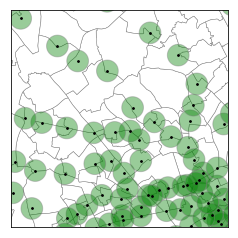

In [945]:
ax = wards.plot(color='white', edgecolor='gray', lw=0.5)
stations.set_geometry('zone').plot(ax=ax, alpha=0.4,edgecolor='gray', color='green')
stations.set_geometry('location').plot(ax=ax, markersize=3, color='k')
ax.set_xlim((690000,700000))
ax.set_ylim((5710000,5720000))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Assuming that passengers enter the station nearest to them, we need to limit the extent of the zones to the Vornoi cell of the station. I.e. the zones should not be overlapping with each other.

In [949]:
# Extract some helpful geometries
shp_london = gpd.read_file('../data/london/shapes/misc/london.shp')
box = shapely.geometry.box(*boroughs.geometry.total_bounds.tolist()).buffer(2000)
box = gpd.GeoDataFrame({'geometry':[box]})
box.crs = stations.crs
external = gpd.overlay(box, boroughs, how='difference')
water = gpd.overlay(external, shp_london, how='intersection')
external = gpd.overlay(external, water, how='difference')
london_nowater = gpd.GeoDataFrame({'geometry':boroughs.union(external)},crs=stations.crs)

/Users/itto/miniconda3/envs/spatial/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:32630', 'no_defs': True} and {'init': 'epsg:32630'}
  other.crs))


In [950]:
# Voronoi cells encompass a large area. Restrict them to London.
stations = gpd.overlay(stations.set_geometry('cell'), box)
stations.rename(columns={'geometry':'cell'},inplace=True)

In [951]:
# Restrict station zones to land
stations = gpd.overlay(stations.set_geometry('zone'), water, how='difference')
stations = stations.dissolve('station', as_index=False)
stations.rename(columns={'geometry':'zone'},inplace=True)

In [953]:
# Restrict zones to be within Voronoi cell
n = stations.shape[0]
stations = gpd.overlay(stations.set_geometry('zone'), stations.loc[:,['station','cell']].set_geometry('cell'))
stations.rename(columns={'geometry':'zone'},inplace=True)
# Each zone overlaps with multiple cells. Only get the cell corresponding to the zone's station.
stations = stations.loc[stations.station_1 == stations.station_2]
# We have duplicate columns. Keep only one. 
stations.drop('station_2',axis=1,inplace=True)
stations.rename(columns={'station_1':'station'},inplace=True)
stations.set_index('station',drop=True,inplace=True)
print('Lost {} rows while overlapping geometries'.format(n - stations.shape[0]))

Lost 1 rows while overlapping geometries


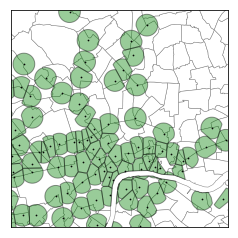

In [954]:
ax = wards.plot(color='white', edgecolor='gray', lw=0.5)
stations.set_geometry('zone').plot(ax=ax, alpha=0.4,edgecolor='black', lw=1, color='green')
stations.set_geometry('location').plot(ax=ax, markersize=0.5, color='k')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim((695000,705000))
ax.set_ylim((5708000,5718000))
plt.show()

We now have a better designation of the area that is represented by our transit-based population estimate. We next need to collect these estimation areas according to the wards that they represent. This involves splitting estimation areas that span multiple wards, and merging two or more estimation areas that both represent the same ward.

## Population modelling

In [955]:
# meas: area to interpolate from, must contain est_key
# unknown: area to interpolate to
# meas_key: label of area to interpolate from
# unknown_key: label of area to interpolate to
# est_key: label of data to interpolate
def interpolate_count(meas, unknown, meas_key, unknown_key, est_key):
    # Overlap with the unknown area, keep both geometries
    meas = gpd.overlay(meas,unknown, how='union')
    # At this point we have measurements at geometries within the interpolation area
    # and at geometries outside. We need to divide the population count weighted by area
    for i,group in meas.groupby(meas_key):
        # Weight based on area of m out of total area of all measurements
        w = group.area/group.area.sum()
        # Assign the weighted average to the estimate
        meas.loc[meas[meas_key] == i,est_key] = w*group[est_key]
    
    # Return the sum of all counts
    meas.geometry = meas.buffer(0.001) # Hack to avoid dissolving issues
    return meas.dissolve(unknown_key, aggfunc='sum', as_index=False)

In [956]:
# meas: area to interpolate from, must contain est_key
# unknown: area to interpolate to
# meas_key: label of area to interpolate from
# unknown_key: label of area to interpolate to
# est_key: label of data to interpolate
def interpolate_rate(meas, unknown, meas_key, unknown_key, est_key):
    # Overlap with the unknown area, discard non-overlapping areas
    meas = gpd.overlay(meas,unknown, how='intersection')

    # Now we have multiple measurements per interpolation area. We need to
    # average the measurements, weighted based on area coverage
    for i,group in meas.groupby(unknown_key):
        # Get weight based on area of measurement out of total area of all measurements
        w = group.area/group.area.sum()
        # Assign the weighted average to the estimate
        meas.loc[meas[unknown_key] == i,est_key] = w*group[est_key]

    # Done interpolation. Dissolve.
    meas.geometry = meas.buffer(0.001) # Hack to avoid dissolving issues
    return meas.dissolve(unknown_key, aggfunc='sum', as_index=False)

In [957]:
# am peak / (mean of off peak + am peak)
def model1(morning,afternoon,off,night):
    prob = morning.max()/(off.mean()+morning.max())
    return prob*morning.sum()

# Morning_max / (mean of off peak + morning max)
def model2(morning,afternoon,off,night):
    return morning.sum()+off.sum()*0.33+night.sum()*0.5


def model3(morning,afternoon,off,night):
    return morning.max()/off.mean()*morning.sum()

def model4(morning,afternoon,off,night):
    return morning.sum()

# Focus on offpeak activity. CBD's are more active in the middle of the day.
def model5(morning,afternoon,off,night):
    return off.sum()

In [966]:
est = model4(data_en.loc[time_of_day=='morning'],
             data_en.loc[time_of_day=='afternoon'],
             data_en.loc[time_of_day=='off'],
             data_en.loc[time_of_day=='night'])

In [967]:
stations['est'] = est.reindex(stations.index) 
stations['density'] = stations.est / stations.set_geometry('zone').area * 1000000

### Wards

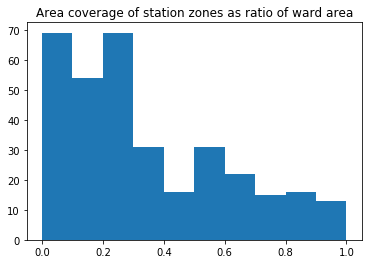

In [960]:
coverage = gpd.overlay(stations.reset_index().set_geometry('zone'), wards, how='intersection')
coverage['AREA'] = coverage.area
coverage = coverage.groupby('wd11cd_bf').AREA.sum()
coverage /= wards.set_index('wd11cd_bf').reindex(coverage.index).area
plt.hist(coverage, bins=10)
plt.title('Area coverage of station zones as ratio of ward area')
plt.show()

In [981]:
est = interpolate_count(stations.reset_index().set_geometry('zone'), wards, 'station', 'wd11cd_bf', 'est')
# Remove values where there are no estimations
est = est.loc[est.est > 0]

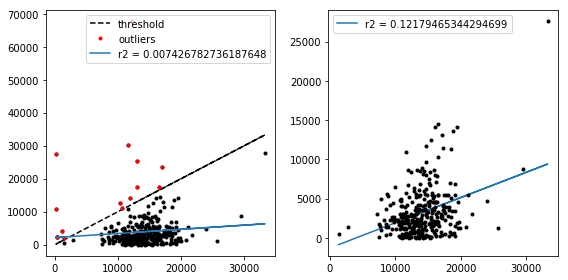

In [984]:
f,(ax1,ax2) = plt.subplots(1,2, figsize=(8,4), sharey=False)
x = wards.set_index('wd11cd_bf').reindex(est.wd11cd_bf).population
y = est.set_index('wd11cd_bf').est
thresh = x
ax1.plot(x, thresh, 'k--', label='threshold')
ax1.plot(x[y > thresh],y[y>thresh],'r.',label = 'outliers')

lin = stats.linregress(x,y)
ax1.plot(x,lin[0]*x+lin[1], label = f'r2 = {lin[2]**2}')
ax1.legend()
ax1.plot(x,y,'k.',zorder=0)

x = x[y < thresh]
y = y[y < thresh]
lin = stats.linregress(x,y)
ax2.plot(x,lin[0]*x+lin[1], label = f'r2 = {lin[2]**2}')
ax2.legend()
ax2.plot(x,y,'k.')
f.tight_layout()

In [1046]:
est_density = interpolate_rate(stations.reset_index().set_geometry('zone'), wards, 'station', 'wd11cd_bf', 'density_actual')
# Remove values where there are no estimations
est_density = est_density.loc[est_density.density > 0]

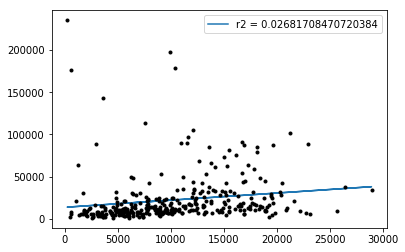

In [1048]:
x = wards.set_index('wd11cd_bf').reindex(est_density.wd11cd_bf).density_actual
y = est_density.set_index('wd11cd_bf').density
thresh = x
# plt.plot(x, thresh, 'k--', label='threshold')
# plt.plot(x[y > thresh],y[y>thresh],'r.',label = 'outliers')
# x = x[y < thresh]
# y = y[y < thresh]
lin = stats.linregress(x,y)
plt.plot(x,lin[0]*x+lin[1], label=f'r2 = {lin[2]**2}')
plt.legend()
plt.plot(x,y,'k.')

### Boroughs

In [986]:
est = interpolate_count(stations.reset_index().set_geometry('zone'), boroughs, 'station', 'lad11nm', 'est')
# Remove values where there are no estimations
est = est.loc[est.est > 0]

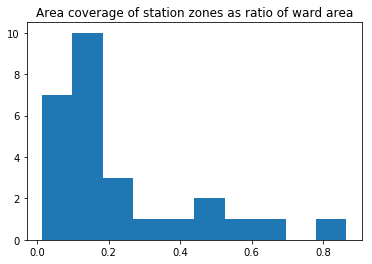

In [971]:
coverage = gpd.overlay(stations.reset_index().set_geometry('zone'), boroughs, how='intersection')
coverage['AREA'] = coverage.area
coverage = coverage.groupby('lad11nm').AREA.sum()
coverage /= boroughs.set_index('lad11nm').reindex(coverage.index).area
plt.hist(coverage, bins=10)
plt.title('Area coverage of station zones as ratio of ward area')
plt.show()

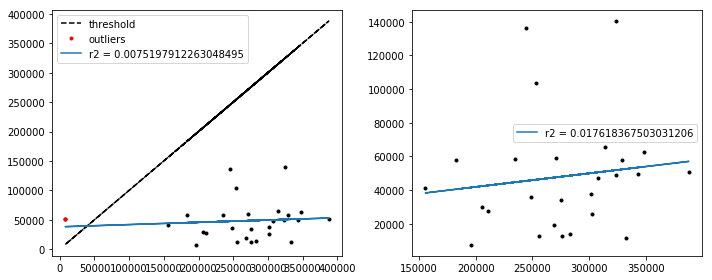

In [991]:
f,(ax1,ax2) = plt.subplots(1,2, figsize=(10,4), sharey=False)
x = boroughs.set_index('lad11nm').reindex(est.lad11nm).population
y = est.set_index('lad11nm').est
thresh = x
ax1.plot(x, thresh, 'k--', label='threshold')
ax1.plot(x[y > thresh],y[y>thresh],'r.',label = 'outliers')

lin = stats.linregress(x,y)
ax1.plot(x,lin[0]*x+lin[1], label = f'r2 = {lin[2]**2}')
ax1.legend()
ax1.plot(x,y,'k.',zorder=0)

x = x[y < thresh]
y = y[y < thresh]
lin = stats.linregress(x,y)
ax2.plot(x,lin[0]*x+lin[1], label = f'r2 = {lin[2]**2}')
ax2.legend()
ax2.plot(x,y,'k.')
f.tight_layout()

In [1055]:
est_density = interpolate_rate(stations.reset_index().set_geometry('zone'), boroughs, 'station', 'lad11nm', 'density')
# Remove values where there are no estimations
est_density = est_density.loc[est_density.density > 0]

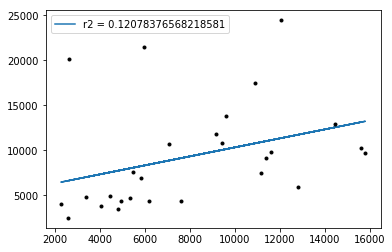

In [1056]:
x = boroughs.set_index('lad11nm').reindex(est_density.lad11nm).density_actual
y = est_density.set_index('lad11nm').density
lin = stats.linregress(x,y)
plt.plot(x,lin[0]*x+lin[1], label=f'r2 = {lin[2]**2}')
plt.legend()
plt.plot(x,y,'k.')

### Output Areas

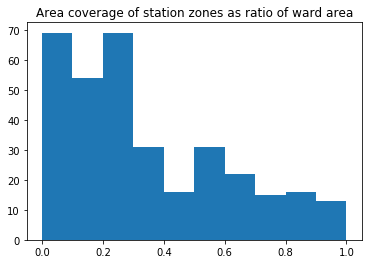

In [960]:
coverage = gpd.overlay(stations.reset_index().set_geometry('zone'), output, how='intersection')
coverage['AREA'] = coverage.area
coverage = coverage.groupby('wd11cd_bf').AREA.sum()
coverage /= wards.set_index('wd11cd_bf').reindex(coverage.index).area
plt.hist(coverage, bins=10)
plt.title('Area coverage of station zones as ratio of ward area')
plt.show()

In [1057]:
%%time
est = interpolate_count(output_areas, stations.reset_index().set_geometry('zone'), 'oa11cd', 'station', 'population')
# Remove values where there are no estimations
est = est.loc[est.population > 0]

CPU times: user 3min 46s, sys: 1.4 s, total: 3min 48s
Wall time: 3min 50s


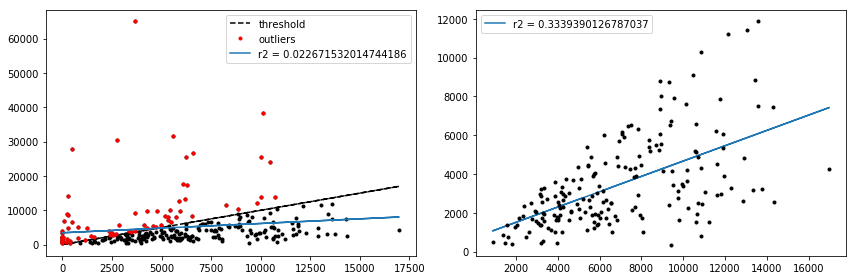

In [1005]:
f,(ax1,ax2) = plt.subplots(1,2, figsize=(12,4), sharey=False)
x = est.set_index('station').population
y = stations.reindex(est.station).est
thresh = x
ax1.plot(x, thresh, 'k--', label='threshold')
ax1.plot(x[y > thresh],y[y>thresh],'r.',label = 'outliers')

lin = stats.linregress(x,y)
ax1.plot(x,lin[0]*x+lin[1], label = f'r2 = {lin[2]**2}')
ax1.legend()
ax1.plot(x,y,'k.',zorder=0)

x = x[y < thresh]
y = y[y < thresh]
lin = stats.linregress(x,y)
ax2.plot(x,lin[0]*x+lin[1], label = f'r2 = {lin[2]**2}')
ax2.legend()
ax2.plot(x,y,'k.')
f.tight_layout()

In [1050]:
%%time
est_density = interpolate_rate(output_areas, stations.reset_index().set_geometry('zone'), 'oa11cd', 'station', 'density')
# Remove values where there are no estimations
est_density = est_density.loc[est_density.density > 0]

CPU times: user 16.7 s, sys: 81.3 ms, total: 16.8 s
Wall time: 16.9 s


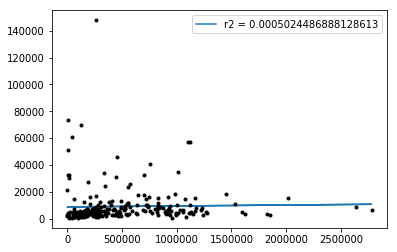

In [1052]:
f,(ax1) = plt.subplots(1,1, figsize=(6,4), sharey=False)
x = est_density.set_index('station').density_actual
y = stations.reindex(est.station).density
thresh = x
lin = stats.linregress(x,y)
ax1.plot(x,lin[0]*x+lin[1], label=f'r2 = {lin[2]**2}')
ax1.legend()
ax1.plot(x,y,'k.')

In [1054]:
import statsmodels.api as sm

In [282]:
data = data_en.T.reindex[y.index]
# data = data.groupby(data.index.hour).sum()
y = test.groupby('station').population.sum()
X = data.T.reindex(test.groupby('station').sum().index)
X = sm.add_constant(X)
est = sm.OLS(y,X).fit()

In [1116]:
from sklearn.preprocessing import StandardScaler

In [1168]:
from sklearn.cross_validation import KFold

In [1244]:
regress.rsquared_adj

0.37989374519973784

In [1261]:
kf = KFold(testX.shape[0],5,shuffle=True)

testX = data_en.groupby(data_en.index.hour).sum()
testX = data_en.loc[~np.isin(time_of_day,['night','morning'])].T.reindex(est.station)
testY = est.set_index('station').population
ss = StandardScaler()
testX_scaled = testX.values
for train_index, test_index in kf:
    trainX = testX_scaled[train_index]
    trainY = testY[train_index]
    valX = testX_scaled[test_index]
    valY = testY[test_index]
    X = sm.add_constant(trainX)
    regress = sm.OLS(trainY,X).fit()
#     print(regress.params.abs().sort_values()[-6:])

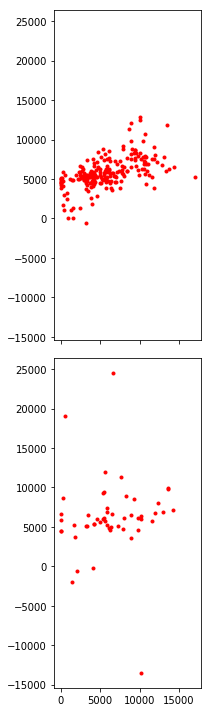

In [1273]:
f, (ax1,ax2) = plt.subplots(2,1,figsize=(12,10),sharey=True, sharex=True)
ax1.plot(trainY, regress.predict(X), 'r.')
ax1.axes.set_aspect('equal')
ax2.plot(valY, regress.predict(sm.add_constant(valX)), 'r.')
ax2.axes.set_aspect('equal')
f.tight_layout()

## Display

In [1274]:
disp1 = gpd.overlay(stations.set_geometry('cell').reset_index(), shp_london).dissolve('station')

/Users/itto/miniconda3/envs/spatial/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:32630', 'no_defs': True} and {'init': 'epsg:32630'}
  other.crs))


In [1277]:
disp1['morning_ratio'] = disp1.morning / (disp1.morning+disp1.night+disp1.afternoon+disp1.off)
disp1['afternoon_ratio'] = disp1.afternoon / (disp1.morning+disp1.night+disp1.afternoon+disp1.off)

[]

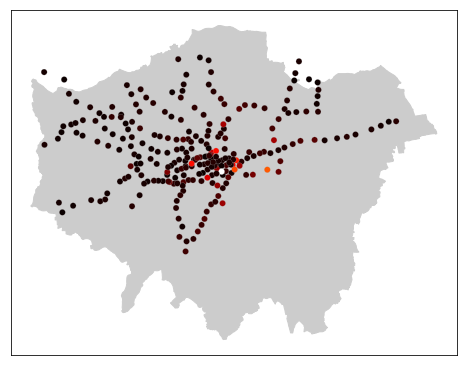

In [1278]:
ax = shp_london.plot(color=[0.8,0.8,0.8], edgecolor=[0.8,0.8,0.8], figsize=(8,8))
disp1.set_geometry('location').plot( ax=ax, column='density', edgecolor =[0.7,0.7,0.7], lw = 0.2,cmap='hot')
ax.set_xticks([])
ax.set_yticks([])

[]

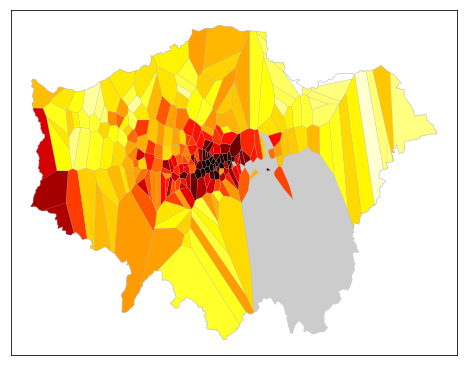

In [1279]:
ax = shp_london.plot(color=[0.8,0.8,0.8], edgecolor=[0.8,0.8,0.8], figsize=(8,8))
disp1.plot( ax=ax, column='morning_ratio', edgecolor =[0.7,0.7,0.7], lw = 0.2,cmap='hot')
ax.set_xticks([])
ax.set_yticks([])

[]

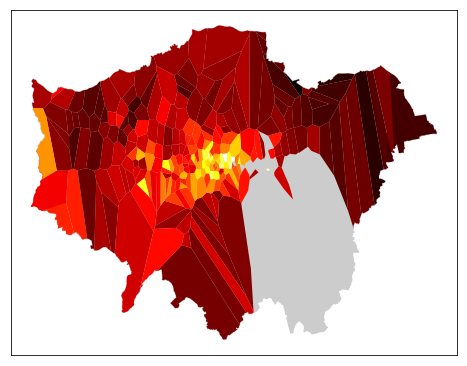

In [1280]:
ax = shp_london.plot(color=[0.8,0.8,0.8], edgecolor=[0.8,0.8,0.8], figsize=(8,8))
disp1.plot( ax=ax, column='afternoon_ratio',lw=0.2,cmap='hot')
ax.set_xticks([])
ax.set_yticks([])

In [109]:
import matplotlib.dates as mdates

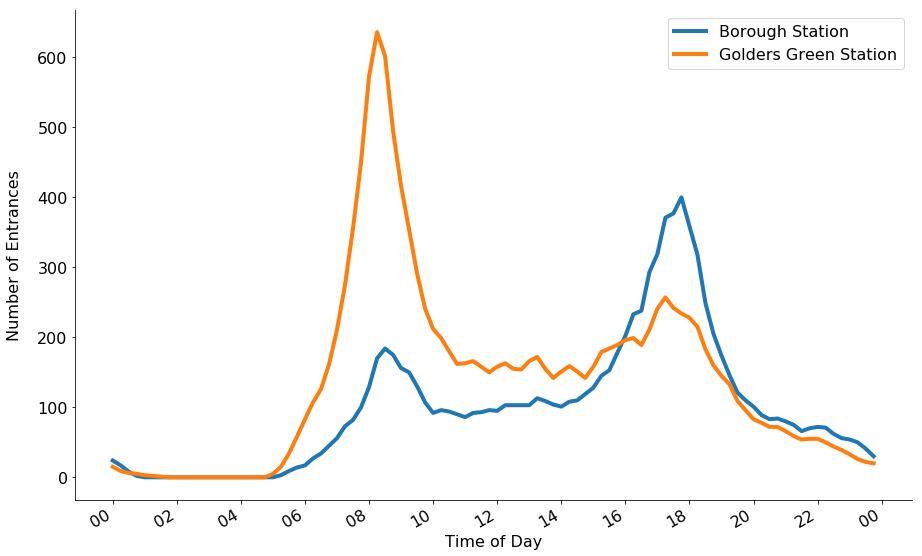

In [160]:
plt.rcParams.update({'font.size': 16})
for station in ['Borough','Golders Green']:
    ax = data_en.loc[:,station].plot(lw=4, figsize=(15,10), label=station+' Station')
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    # ax.yaxis.grid()
    # ax.xaxis.grid()
    ax.locator_params(axis='y', nbins=7)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Number of Entrances', labelpad=15)
#     ax.set_title('Station entrances on a weekday',pad=20,fontdict={'fontsize':20})
plt.legend()
plt.savefig('/Users/itto/Desktop/entrances.png')

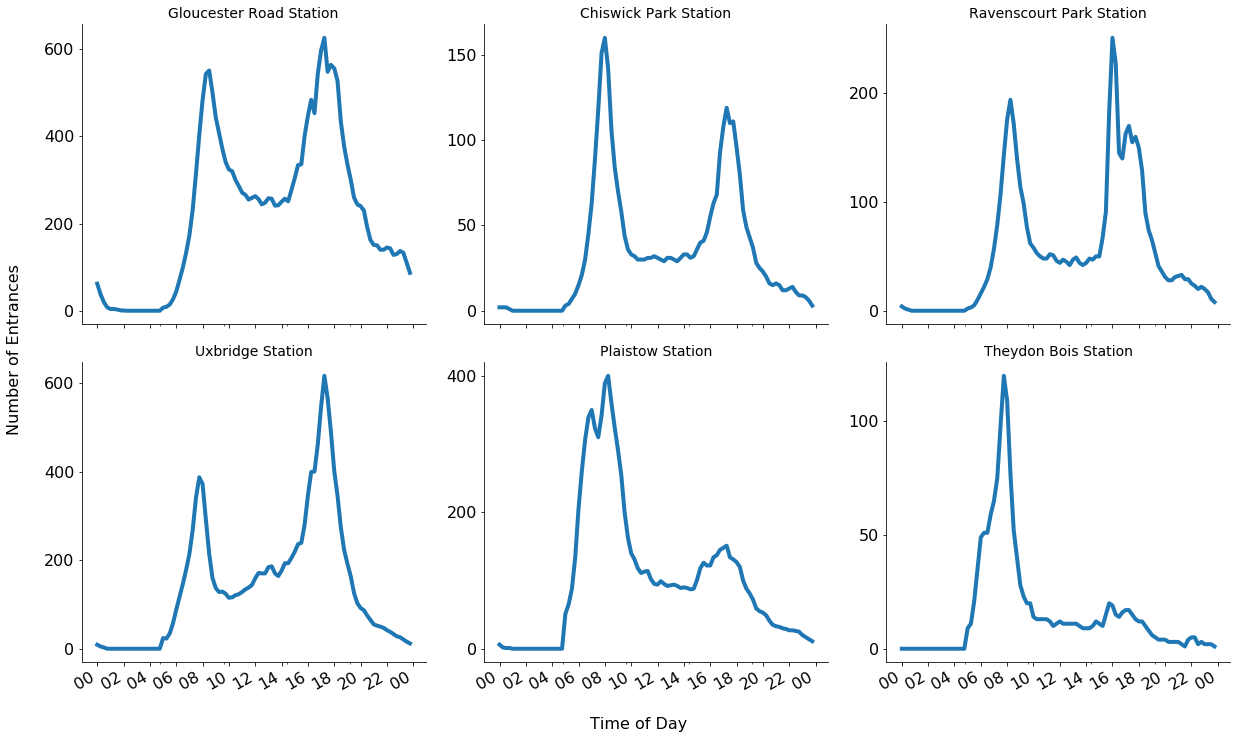

In [208]:
montage = data_en.sample(6,axis=1,random_state=42)
f,axes = plt.subplots(2,3,figsize=(17,10),sharex=True,sharey=False)
axes = axes.flatten()
for i,ax in enumerate(axes):
    montage.iloc[:,i].plot(ax=ax, lw=4)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.locator_params(axis='y', nbins=4)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(montage.columns[i]+' Station',fontdict={'fontsize':14})
f.text(-0.01, 0.5, 'Number of Entrances', ha='center', va='center', rotation='vertical')
f.text(0.5, -0.02, 'Time of Day', ha='center', va='center')
f.tight_layout()

In [344]:
nodes = pd.read_csv('../data/london/network/nodes.csv')
nodes['geometry'] = [shapely.geometry.Point(p) for p in list(zip(nodes.longitude.values, nodes.latitude.values))]
nodes = gpd.GeoDataFrame(nodes)
nodes.crs = {'init' :'epsg:4326'}
nodes.to_crs(epsg= PROJECTION, inplace=True)

In [345]:
node_map = nodes.set_index('id')['geometry'].to_dict()

In [346]:
lines = pd.read_csv('../data/london/network/lines.csv')
lines['point1'] = lines.station1.map(node_map)
lines['point2'] = lines.station2.map(node_map)
lines = gpd.GeoDataFrame(lines)
lines.crs = nodes.crs

In [347]:
lines['geometry'] = ([shapely.geometry.LineString([p1,p2]) for (p1,p2) in lines[['point1','point2']].values])

In [112]:
entrances['total'] = entrances.afternoon + entrances.night + entrances.off + entrances.morning
entrances['morning_max'] = data_en.loc[time_of_day == 'morning'].max()
entrances['afternoon_max'] = data_en.loc[time_of_day == 'afternoon'].max()
entrances['off_mean'] = data_en.loc[time_of_day == 'off'].mean()

In [497]:
ratio_morn = (entrances.morning_max / entrances.off_mean)
ratio_afternoon = (entrances.afternoon_max / entrances.off_mean)

In [498]:
# Get all stations above the zero intersection
hotspots_work = ratio_afternoon.sort_values().iloc[x[tangent_zero:]].index
hotspots_work = stations.reindex(hotspots_work)
hotspots_work.dropna(subset=['location'],inplace=True)

In [499]:
# Get all stations above the zero intersection
hotspots_res = ratio_morn.sort_values().iloc[x[tangent_zero:]].index
hotspots_res = stations.reindex(hotspots_res)
hotspots_res.dropna(subset=['location'],inplace=True)

/Users/itto/miniconda3/envs/spatial/lib/python3.6/site-packages/matplotlib/legend.py:592: UserWarning: The handle <matplotlib.lines.Line2D object at 0x12238f6d8> has a label of '_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Users/itto/miniconda3/envs/spatial/lib/python3.6/site-packages/matplotlib/legend.py:592: UserWarning: The handle <matplotlib.lines.Line2D object at 0x12238f898> has a label of '_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


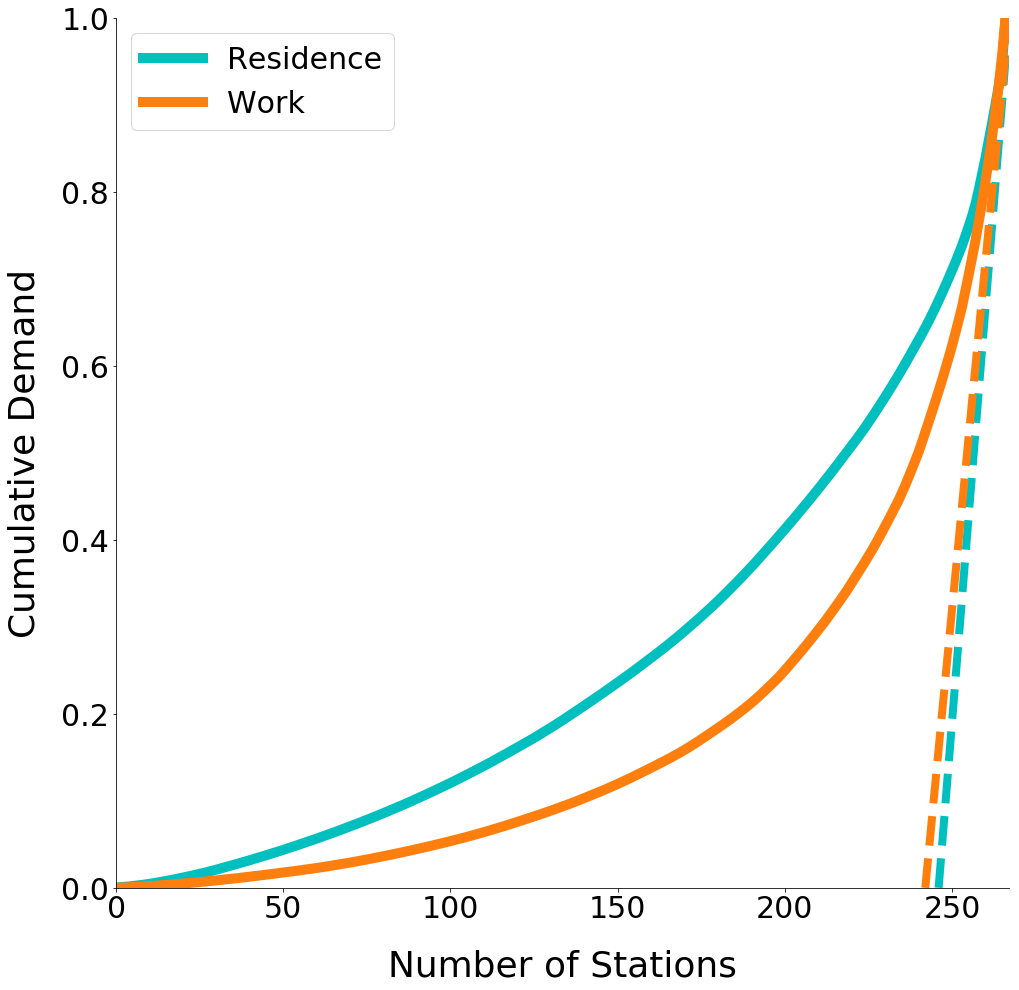

In [492]:
f,ax = plt.subplots(1,1, figsize=(16,16))

x = range(y.shape[0])
y = (ratio_morn.sort_values()/ratio_morn.sum()).cumsum().values
tangent_slope = (y[-1] - y[-2])/(x[-1] - x[-2])
tangent_zero = x[-1] - y[-1]/tangent_slope
# Round
ax.plot(y, 'c',lw=10)
ax.plot([tangent_zero, y.shape[0]], [0, y[-1]], 'c', ls='dashed', lw=8)

x = range(y.shape[0])
y = (ratio_afternoon.sort_values()/ratio_afternoon.sum()).cumsum().values
tangent_slope = (y[-1] - y[-2])/(x[-1] - x[-2])
tangent_zero = x[-1] - y[-1]/tangent_slope
# Round
tangent_zero = int(tangent_zero)
ax.plot(y, 'C1',lw=10)
ax.plot([tangent_zero, y.shape[0]], [0, y[-1]], 'C1', ls='dashed', lw=8)

ax.legend(['Residence','_','Work','_'])

ax.set_xlabel('Number of Stations',labelpad=25, fontdict={'fontsize':36})
ax.set_ylabel('Cumulative Demand',labelpad=20, fontdict={'fontsize':36})


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.margins(0)

plt.rcParams.update({'font.size': 30})

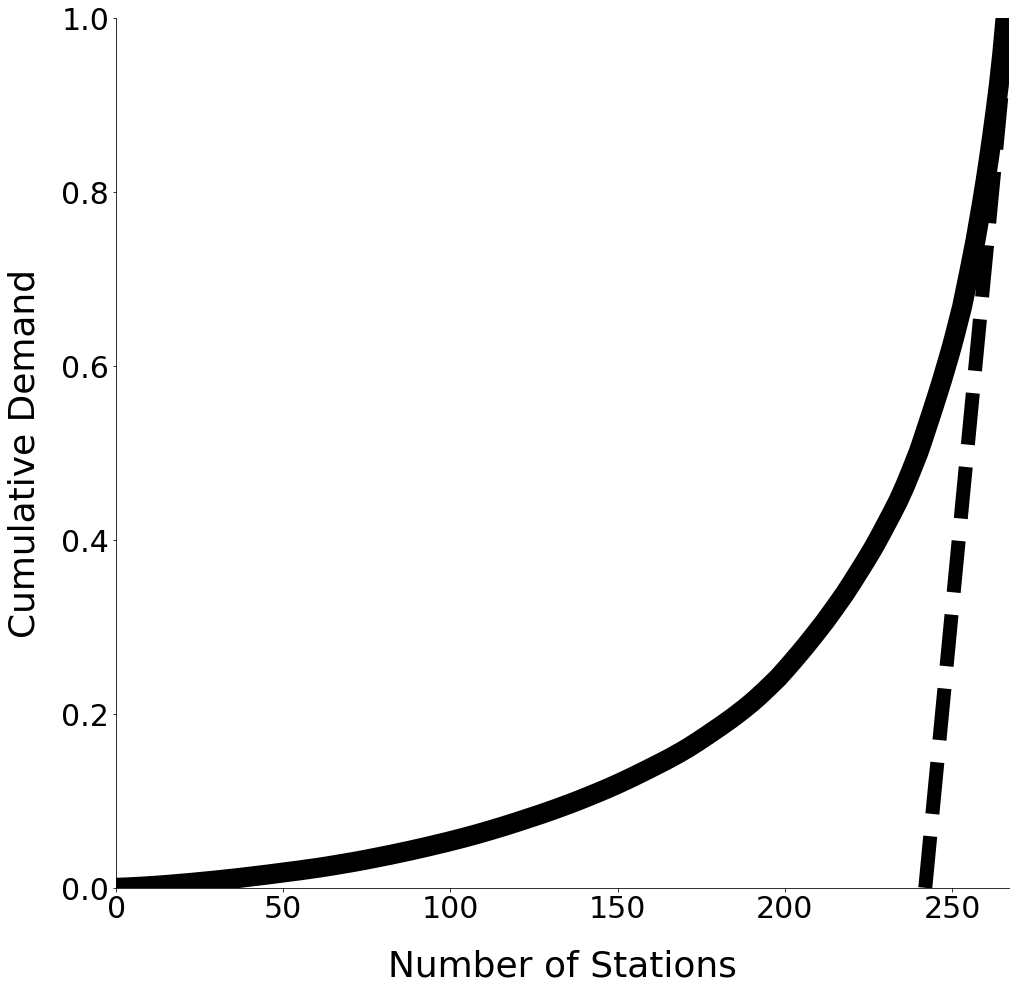

In [496]:
f,ax = plt.subplots(1,1, figsize=(16,16))

x = range(y.shape[0])
y = (ratio_afternoon.sort_values()/ratio_afternoon.sum()).cumsum().values
tangent_slope = (y[-1] - y[-2])/(x[-1] - x[-2])
tangent_zero = x[-1] - y[-1]/tangent_slope
# Round
tangent_zero = int(tangent_zero)
ax.plot(y, 'k',lw=20)
ax.plot([tangent_zero, y.shape[0]], [0, y[-1]], 'k', ls='dashed', lw=14)

ax.set_xlabel('Number of Stations',labelpad=25, fontdict={'fontsize':36})
ax.set_ylabel('Cumulative Demand',labelpad=20, fontdict={'fontsize':36})

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.margins(0)
plt.rcParams.update({'font.size': 30})

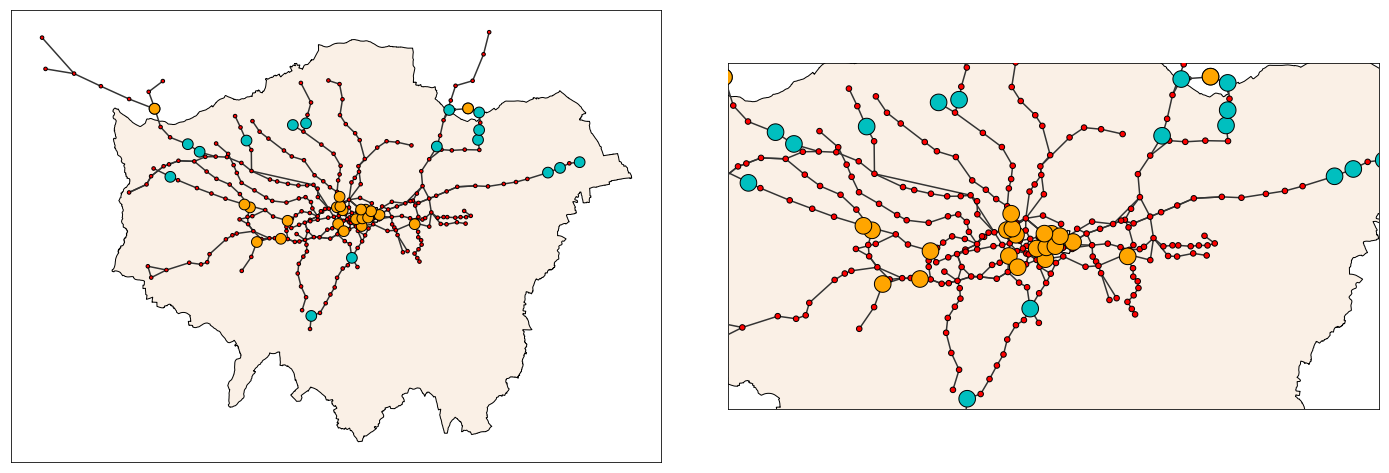

In [513]:
f,(ax1,ax2) = plt.subplots(1,2, figsize=(20,12))
shp_london.plot(ax=ax1,color='linen',edgecolor='k',zorder=0)
# hotspots_res.set_geometry('zone').plot(ax = ax1,color='c',alpha=0.5,zorder=1)
# hotspots_work.set_geometry('zone').plot(ax = ax1,color='orange',zorder=1)
lines.plot(ax=ax1, color=[0.2,0.2,0.2], zorder=4)
nodes.buffer(200).plot(ax=ax1, edgecolor='k', color='r', zorder=5)
hotspots_res.set_geometry('location').buffer(600).plot(ax=ax1, edgecolor='k', color='c', zorder=5)
hotspots_work.set_geometry('location').buffer(600).plot(ax=ax1, edgecolor='k', color='orange', zorder=5)
ax1.set_xticks([])
ax1.set_yticks([])
# Zoom in
shp_london.plot(ax=ax2,color='linen',edgecolor='k',zorder=0)
# hotspots_res.set_geometry('zone').plot(ax = ax2,color='c',alpha=0.5,zorder=1)
# hotspots_work.set_geometry('zone').plot(ax = ax2,color='orange',zorder=1)
lines.plot(ax=ax2, color=[0.2,0.2,0.2], zorder=4)
nodes.buffer(200).plot(ax=ax2, edgecolor='k', color='r', zorder=5)
hotspots_res.set_geometry('location').buffer(600).plot(ax=ax2, edgecolor='k', color='c', zorder=5)
hotspots_work.set_geometry('location').buffer(600).plot(ax=ax2, edgecolor='k', color='orange', zorder=5)

ax2.set_xlim((678000,725000))
ax2.set_ylim((5699000,5724000))
ax2.set_xticks([])
ax2.set_yticks([])

f.tight_layout(w_pad=2)

${P = \sum w_t E_t + \varepsilon}$

${\varepsilon = E_{outgoing} - E_{incoming}}$